# PROJECT: ControlNet으로 조건을 준 이미지 생성하기

<br> 

## 개요
지금까지는 Stable Diffusion 모델만을 이용하여 이미지를 생성하거나 이미지의 스타일을 바꾸는 실습을 해보았다. 이번에는 여기서 조금 더 나아가서 ControlNet을 이용하여 이미지에 조건을 주어 이미지를 다양하게 변형해보려고 한다.  
  
* ControlNet이란?
> Stable Diffusion은 텍스트 프롬프트 또는 입력 이미지를 통하여 이미지를 생성하지만 생성된 이미지를 원하는 대로 출력하기 어렵다. 아무리 프롬프트를 자세하게 써도 생성되는 이미지가 내가 원하는 자세, 구도, 배경을 갖도록 하는 것은 거의 불가능하다. ControlNet은 Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할ㅇ 수 있다. 뿐만 아니라 ControlNet은 훈련데이터가 작아도 학습이 잘 되고 빠르다는 장점이 있어 개인용 기기에서 사용할 수 있다는 장점으로 연결된다.  
ControlNet은 논문 '[Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)'에서 소개되었고, 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시멘틱 세그멘테이션(Sementic segmentation) 등 다양한 전처리기를 Stable Diffusion 모델에 도입할 수 있다. 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있다.  

## 목차
* 필요한 라이브러리 설치
* 윤곽선 검출
* 인체 자세 감지
* 윤곽선 검출 + 인체 자세 감지
    * Canny 알고리즘을 사용한 윤곽선 검출
    * Openpose를 사용한 인체 자세 검출

### 필요한 라이브러리 설치
---
프로젝트를 진행함에 앞서 필요한 라이브러리를 설치 및 import한다.

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 44 kB 3.4 MB/s             


In [3]:
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  
from controlnet_aux import OpenposeDetector 
from PIL import Image 

import torch
import cv2
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### 윤곽선 검출
---
윤곽선을 검출해본다. ControlNet은 다양한 윤곽선 검출 알고리즘을 제공하지만, 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 Canny 알고리즘을 사용하도록 한다.  
먼저 이미지를 불러오고, 누구나 익히 아는 이미지를 사용한다.

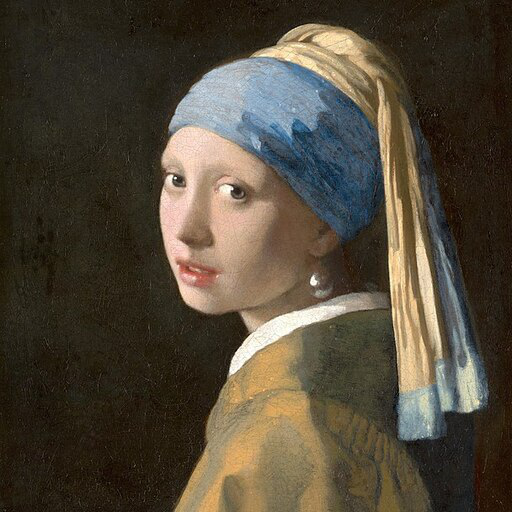

In [4]:
# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

OpenCV를 사용하여 이미지의 윤곽선을 검출한다.

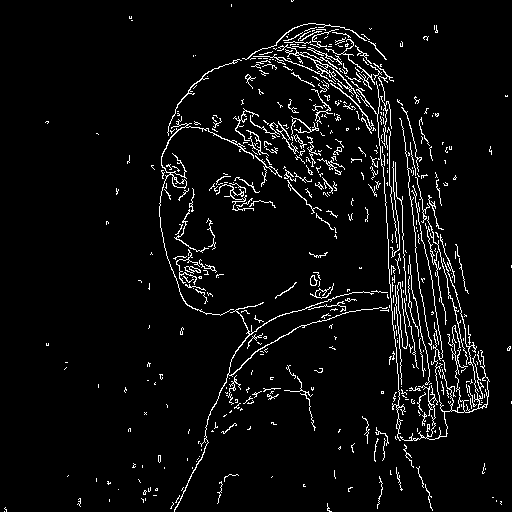

In [5]:
# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러온다.

In [6]:
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성한다.

  0%|          | 0/20 [00:00<?, ?it/s]

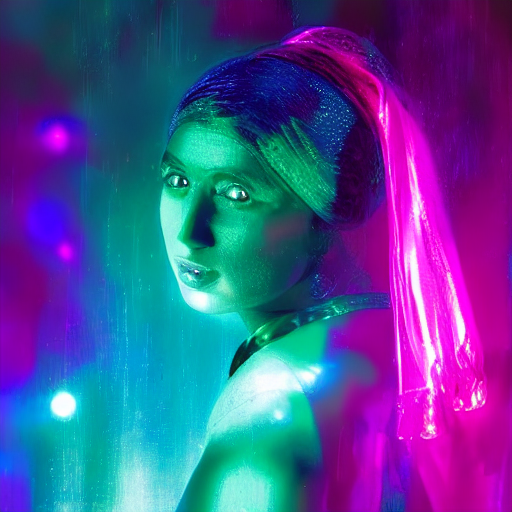

In [8]:
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있다.

* `negative_propmt`: 원하지 않는 요소를 적을 수 있다.
* `controlnet_conditioning_scale`: ContorlNet으로 조건을 어느 정도 주느냐를 조절한다. Default는 1이고, 실수값으로 설정할 수 있다.
* `num_inference_steps`: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸린다. default 값은 50이다.
* `guidance_scale`: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있다. default는 7.5이다.

프롬프트와 부정적인 프롬프트는 ChatGPT를 이용하여 생성해 보도록 한다.

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


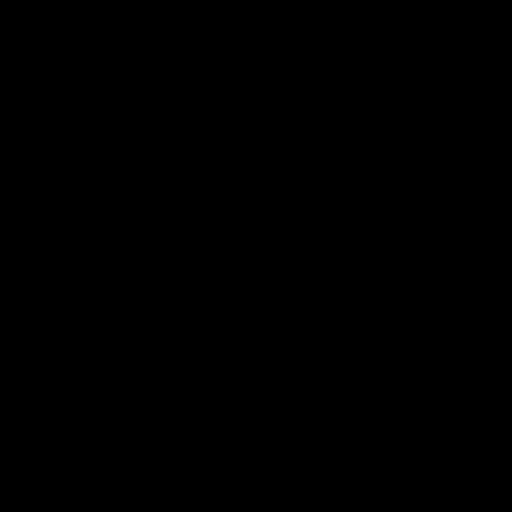

In [17]:
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# positive prompt와 negative prompt를 정의합니다.
positive_prompt = "korean idol with a fancy stage costume"
negative_prompt = "not a korean Idol"

# 이미지를 생성합니다.
canny_image = canny_pipe(
  prompt=[positive_prompt, negative_prompt], 
  num_inference_steps=25, 
  generator=generator, 
  image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image1.png")  

# 생성된 이미지를 출력합니다. 
canny_image

이미 생성된 canny_image에 재생성을 시도해서 검정 화면이 출력되는 것 같다.  
이미지를 다시 불러와서 처음부터 진행해보도록 한다.

In [18]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

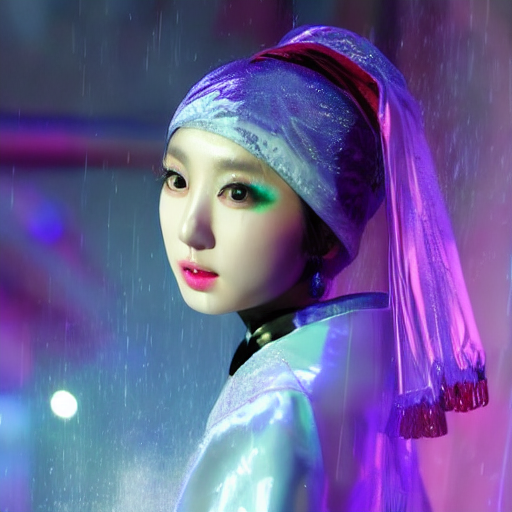

In [19]:
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# positive prompt와 negative prompt를 정의합니다.
positive_prompt = "korean idol with a fancy stage costume"
negative_prompt = "not a korean Idol"

# 이미지를 생성합니다.
canny_image = canny_pipe(
  prompt=[positive_prompt, negative_prompt], 
  num_inference_steps=25, 
  generator=generator, 
  image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image1.png")  

# 생성된 이미지를 출력합니다. 
canny_image

약간...공민지...?나연...?여하튼 아이돌 페이스가 된 것 같다...

### 인체 자세 감지
---
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기이다. 자세를 감지하여 새로운 이미지를 생성해 준다.  
사람의 전신이 담긴 이미지를 불러오도록 한다.

In [20]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

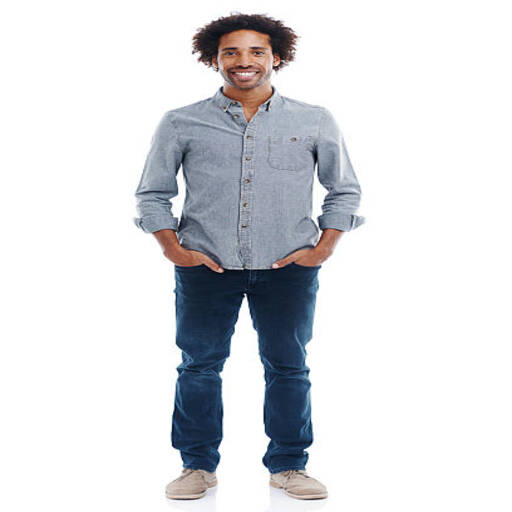

In [24]:
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

Openpose 검출기를 사용하면 자세만 추출할 수 있다.

cuda


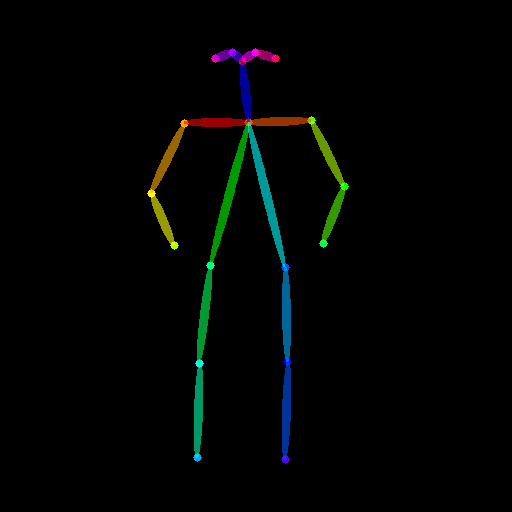

In [25]:
# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

Openpose 전처리기를 사용한 모델 파이프라인을 불러온다.

In [26]:
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

새로운 이미지를 생성해 보도록 한다. Canny Edge Detection에서 사용한 코드를 참고하고, 하이퍼파라미터를 조절하면 더 퀄리티가 좋은 이미지를 생성할 수 있다.

  0%|          | 0/25 [00:00<?, ?it/s]

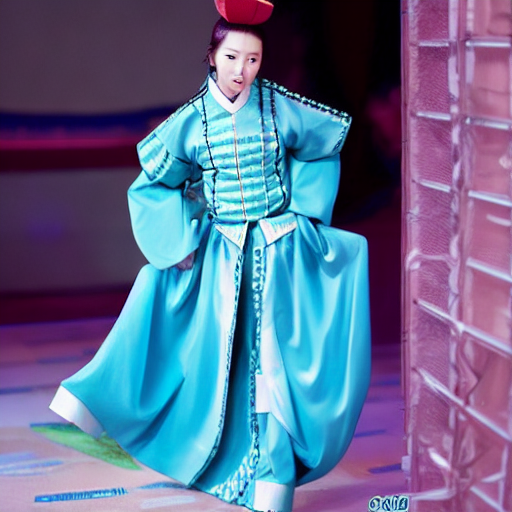

In [27]:
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)  

#프롬프트를 작성합니다. 
positive_prompt = "korean model with a fancy stage costume"
negative_prompt = "not a korean model"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
  prompt=[positive_prompt, negative_prompt], 
  num_inference_steps=25, 
  generator=generator, 
  image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/25 [00:00<?, ?it/s]

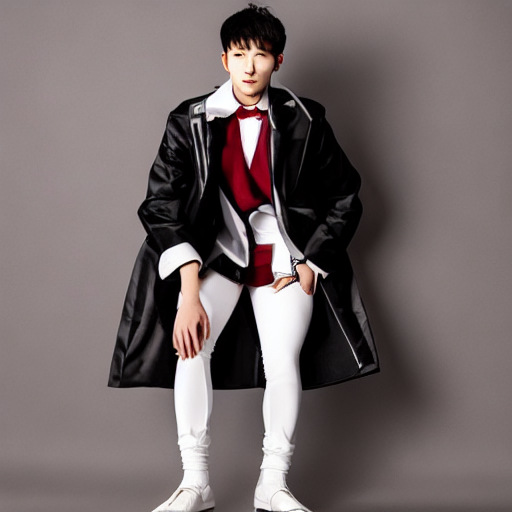

In [28]:
#프롬프트를 작성합니다. 
positive_prompt = "korean male model with a modern stage costume"
negative_prompt = "not a korean model with traditional costume"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image2 = openpose_pipe(
  prompt=[positive_prompt, negative_prompt], 
  num_inference_steps=25, 
  generator=generator, 
  image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image2

나폴레옹인가...

### 윤곽선 검출 + 인체 자세 감지
---
이번에는 위에서 실습한 2가지의 전처리기를 동시에 사용해 보도록 한다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 된다.

#### Canny 알고리즘을 사용한 윤곽선 검출
먼저 Canny 알고리즘으로 윤곽선을 검출한다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하도록 한다.

In [33]:
# 이미지를 불러오세요. 
canny_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

#### Openpose를 사용한 인체 자세 검출
인체 자세를 검출해보도록 한다.

In [31]:
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달한다.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

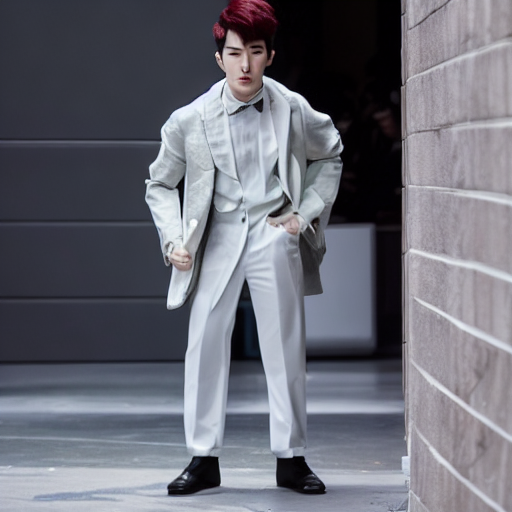

In [35]:
torch.cuda.empty_cache()
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
positive_prompt = "korean male model with a modern stage costume"
negative_prompt = "not a korean model with traditional costume"

# seed를 지정합니다. 
generator = torch.manual_seed(0)  

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = openpose_pipe(
  prompt=[positive_prompt, negative_prompt], 
  num_inference_steps=25, 
  generator=generator, 
  image=images
).images[0]

# 생성된 이미지를 저장합니다.
# image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

인피니트 성규...?

## 회고
---
비록 시간이 없어 제대로 파보진 못했지만, 노드 정리를 할 때 다시 한 번 그 원리를 분석해보고 싶다.